In [ ]:
# Genetic Algorithm - Graph Colouring Problem
# Project for Evolutionary Algorithms class at VUT FIT Brno
# Date: March 2023
# Author: Bc. Sebastian Krajnak
# Genetic operations, chromosone representation based on:
# Genetic Algorithm Applied to the Graph Coloring Problem (Musa M Hindi, Roman Yampolskiy)
# Some functions used were either copied or edited from EVO Lab 2 code by Ing. Martin Hurta

import numpy as np
import matplotlib.pyplot as plt
import random
from math import ceil
import csv

In [ ]:
# BIN extension----------------------------------------------------------------------
# Generate graph
# graph will be represented by an adjacency matrix where 1's mean the vertices are connected
# the graph is unordered so it is symmetrical and has 0s on the main diagonal
def generate_graph(n):
  print("Generating adjacency matrix...")
  num_vertices = n
  graph = [[0] * num_vertices for _ in range(num_vertices)]
  num_edges = 0

  while(num_edges != int( (num_vertices**2)/4*3/2 )):
      vertex1, vertex2 = random.sample(range(num_vertices),2)
      if(graph[vertex1][vertex2] != 1):
        graph[vertex1][vertex2] = 1
        graph[vertex2][vertex1] = 1
        num_edges += 1

  print(f"done! Graph has {num_vertices} vertices and {num_edges} edges")

  return graph, num_edges, num_vertices

def compute_upper_bound(current_upper=float('inf')):
  initial_upper = np.max(np.diag(np.sum(np.array(graph), axis =1) ))
  if current_upper == float('inf'):
    return initial_upper
  elif current_upper <= initial_upper:
    return current_upper - 2

graph, num_edges, num_vertices = generate_graph(25)
chromatic_number = compute_upper_bound()
print(f"Chromatic number upper bound is {chromatic_number}")

#Helper function from github to check if generated graph is symmetric
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
print(f"Is graph symmetrical ? {check_symmetric(np.array(graph))}")

Generating adjacency matrix...
done! Graph has 25 vertices and 234 edges
Chromatic number upper bound is 22
Is graph symmetrical ? True


In [ ]:
# Load graphs from .col files -------------------------------------------------------
def parse_file(filename):
    print(f"Creating a graph from file {filename}")
    with open(filename, 'r') as f:
        # Skip lines until we reach the line starting with 'p edge'
        line = f.readline().strip()
        while not line.startswith('p edge'):
            line = f.readline().strip()

        # Get the number of vertices from the 'p edge' line
        num_vertices = int(line.split()[2])
        num_edges = int(line.split()[3])

        # Create an empty adjacency matrix
        adjacency_matrix = [[0] * num_vertices for _ in range(num_vertices)]

        # Parse the edges and update the adjacency matrix
        for line in f:
            if line.startswith('e'):
                _, v1, v2 = line.split()
                v1, v2 = int(v1) - 1, int(v2) - 1  # Convert to 0-indexed
                adjacency_matrix[v1][v2] = 1
                adjacency_matrix[v2][v1] = 1  # Assuming undirected graph
        print(f"...done! Graph has {num_vertices} vertices and {int(num_edges/2)} edges.")
        return adjacency_matrix, num_vertices

graph_files = [ # list of tuples where (graph_file, known_chromatic_number)
    ("graphs/miles250.col", 8),
    ("graphs/miles1000.col", 42),
    ("graphs/queen5_5.col", 5),
    ("graphs/queen7_7.col", 7),
    ("graphs/huck.col", 11)
    ]
graph, num_vertices = parse_file(graph_files[1][0])
chromatic_number = graph_files[1][1]

Creating a graph from file graphs/miles1000.col
...done! Graph has 128 vertices and 3216 edges.


In [ ]:
# Variables to tweak with -----------------------------------------------------------
# all variables used for the evolution are easily found on one place here
num_runs = 15

num_generations = 10000
population_size = 50
mutation_probability = 0.187654
crossover_probability = 0.869420
all_fitness = np.array([])

csv_name = "fitness.csv"

In [ ]:
# Genetical operators ---------------------------------------------------------------
def tournament_selection(population, scores, k=2): # Author: Ing. Martin Hurta

    # Getting random ordering of individuals
    random_order = list(range(0, len(population)))
    np.random.shuffle(random_order)

    # Selecting the first individual to start with
    best_idx = random_order[0]

    # Tournament selection with the remaining individuals and saving the individual with the lowest fitness
    for i in range(1, k):

        if scores[random_order[i]] < scores[best_idx]:
            best_idx = random_order[i]

    return population[best_idx]

def fitness(solution): # Penalty for every vertex connecting 2 nodes with the same color
    fitness = 0
    for i in range(num_vertices):
        for j in range(i, num_vertices):
            if(solution[i] == solution[j] and graph[i][j] == 1):
                fitness += 1
    return fitness

def single_point_crossover(p1, p2, crossover_probability): # Author: Ing. Martin Hurta

    # Children initialization
    c1, c2 = p1.copy(), p2.copy()

    # Checking if crossover will happen
    if np.random.uniform() < crossover_probability:

        # Selecting a non-finite point for crossover
        pt = np.random.randint(1, len(p1)-2)

        # Crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

# Helper function for mutations, finds all colours adjecent to given vertex
def find_adjecent_colors(vertex, chromosone):
  adj_vertices = graph[vertex]
  adj_colors = [chromosone[i] for i in range(len(chromosone)) if adj_vertices[i] == 1]

  return adj_colors

# Mutation function used when fitness > 4
def mutation_high_fit(chromosone, mutation_probability, chromatic_num):
  all_colors = [i for i in range(chromatic_num)]
  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)
    if chromosone[vertex] in adj_colors:
      valid_colors = [all_colors[i] for i in range(chromatic_num) if all_colors[i] not in adj_colors]

      if(valid_colors): # If list is empty choose random color
        new_color = random.choice(valid_colors)
      else:
        new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

# Mutation function when fitness value is <= 4
def mutation_low_fit(chromosone, mutation_probability, chromatic_num):
  all_colors = list(range(chromatic_num))

  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)
    if chromosone[vertex] in adj_colors:
      new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

# Mutation function used when fitness is not making progress for a set amount of generations
def mutation_problem_individuals(chromosone, mutation_probability, chromatic_num):
  all_colors = list(range(chromatic_num))
  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)

    for j in range(vertex, num_vertices):
      if(chromosone[vertex] == chromosone[j] and graph[vertex][j] == 1):
        valid_colors = [all_colors[i] for i in range(chromatic_num) if all_colors[i] not in adj_colors]

        if(valid_colors): # If list is empty choose random color
          new_color = random.choice(valid_colors)
        else:
          new_color = random.choice(all_colors)
        chromosone[vertex] = new_color

def mutation_CHATGPT(chromosone, mutation_probability, chromatic_num, graph):
  all_colors = set(range(chromatic_num))
  adj_dict = {v: set() for v in range(len(chromosone))}
  for i in range(len(chromosone)):
    for j in range(len(chromosone)):
      if i != j and graph[i][j] == 1:
        adj_dict[i].add(j)
        adj_dict[j].add(i)

  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = {chromosone[v] for v in adj_dict[vertex]}

    valid_colors = all_colors - adj_colors
    if valid_colors:
      new_color = random.choice(tuple(valid_colors))
    else:
      new_color = random.choice(tuple(all_colors))
    chromosone[vertex] = new_color


In [ ]:
# Genetic algorithm ----------------------------------------------------------------------
# Author of the original algorithm Ing. Martin Hurta with editions by me
def genetic_algorithm(num_generations, population_size, crossover_probability, chromatic_num, mutation_probability, all_fitness):
    # Random initial population inicialization
    population = [np.random.randint(0, chromatic_num-1, num_vertices).tolist() for _ in range(population_size)]

    # Inicialization of the best initial individuals
    best_individual = 0
    best_eval = fitness(population[0])
    new_best = -1
    best_history = []

    # Evolution
    gen = 0
    eval_counter = 0 # BIN only
    chromatic_history = [] # BIN only
    while(gen != num_generations and best_eval != 0):
        # BIN extension comment if solving EVO only
        """ if best_eval <= 5:
           eval_counter += 1
        if eval_counter == 5 and chromatic_num != 1:
          chromatic_num = compute_upper_bound(chromatic_num)
          population = [np.random.randint(0, chromatic_num-1, num_vertices).tolist() for _ in range(population_size)]
          best_individual = 0
          best_eval = fitness(population[0])
          new_best = -1
          eval_counter = 0 """

        # Fitness score evaluation in canditate population
        scores = [fitness(indivitual) for indivitual in population]

        # Get best solution in population
        for i in range(population_size):
            if scores[i] < best_eval:
                best_individual = population[i]
                best_eval = scores[i]
                new_best = i

        # Display information about new best solution
        if new_best != -1:
            print(">%d, new best f(%s) = %d, chromatic number = " % (gen,  population[new_best], scores[new_best]), chromatic_num)
            best_history.append([gen, scores[new_best]])
            chromatic_history.append(chromatic_num)
            with open(csv_name, 'a') as csvfile:
              csvwriter = csv.writer(csvfile)
              csvwriter.writerow([gen, scores[new_best], chromatic_num])
            new_best = -1
        else:
          eval_counter += 1

        # Parents selection in the size of the whole population
        selected = [tournament_selection(population, scores) for _ in range(population_size)]
        all_fitness = np.append(all_fitness, best_eval)
        next_gen_parents = selected[:int(population_size/2)]
        population = next_gen_parents


        # Creating the next generation
        for i in range(0, int(population_size/2), 2):

            # Parent selection for crossover
            p1, p2 = selected[i], selected[i+1]

            # Probability dependent crossover
            for c in single_point_crossover(p1, p2, crossover_probability):

                # Mutation of individuals
                if best_eval > 4:
                  mutation_high_fit(c, mutation_probability,chromatic_num)
                elif eval_counter == int(num_generations/6):
                  mutation_problem_individuals(c, mutation_probability, chromatic_num)
                  print(f"Mutating problem individuals, no progress in {eval_counter} generations...")
                  eval_counter = 0
                else:
                  mutation_low_fit(c, mutation_probability,chromatic_num)

                # Appending children to the next generation
                population.append(c)

        gen += 1
        #print(f"Eval counter is {eval_counter}")
        if(gen == num_generations):
          print("Max number of generations reached ! Stopping evolution...")

    return [best_individual, best_eval, best_history, all_fitness, chromatic_history]


Ideas to plot
1. y= fitness x= different values for mut_prob BOXPLOT
2. y= fitness x= different values for pop_size BOXPLOT => bigger pop needs lower num of runs pocet evaluaci sa musi rovnat ( GEN_SIZE * POP_SIZE)
3. median, max, min, q2, q4 NOT as a boxplot but as a konvergencni krivka EVO lecture 9

grafy stacia maly (queen6_6.col), velky(queen8_8.col), s malym (miles250.col) a velkym(miles1000.col) prepojenim
prezentacia je len jedna pre BIN a EVO



>0, new best f([5, 16, 31, 2, 6, 16, 9, 14, 16, 15, 20, 15, 3, 20, 13, 11, 30, 17, 30, 18, 36, 36, 34, 27, 31, 35, 19, 35, 31, 0, 0, 12, 13, 11, 2, 14, 40, 29, 8, 36, 30, 3, 26, 20, 37, 4, 8, 18, 5, 8, 0, 19, 27, 12, 10, 37, 36, 25, 36, 21, 38, 13, 10, 17, 18, 30, 5, 22, 3, 27, 28, 24, 18, 10, 39, 3, 40, 28, 37, 20, 17, 9, 33, 21, 19, 7, 21, 20, 33, 3, 15, 7, 30, 7, 13, 1, 1, 34, 1, 12, 5, 16, 25, 12, 27, 33, 32, 29, 39, 21, 10, 9, 40, 32, 24, 38, 12, 17, 11, 6, 30, 11, 34, 22, 30, 6, 6, 13]) = 54, chromatic number =  42
>1, new best f([36, 17, 22, 34, 19, 21, 5, 6, 31, 25, 35, 30, 33, 36, 38, 0, 13, 4, 32, 27, 24, 4, 9, 34, 19, 4, 39, 40, 13, 16, 31, 10, 1, 11, 34, 35, 33, 22, 20, 25, 18, 37, 28, 30, 10, 30, 27, 12, 3, 20, 16, 27, 1, 26, 32, 17, 2, 6, 12, 1, 5, 38, 39, 19, 24, 28, 10, 11, 29, 15, 13, 24, 37, 15, 27, 22, 30, 24, 33, 4, 17, 21, 0, 1, 36, 35, 23, 14, 0, 41, 37, 8, 3, 12, 29, 13, 9, 35, 12, 35, 35, 17, 22, 31, 7, 22, 6, 22, 3, 23, 20, 2, 13, 21, 38, 26, 26, 16, 21, 40, 5,

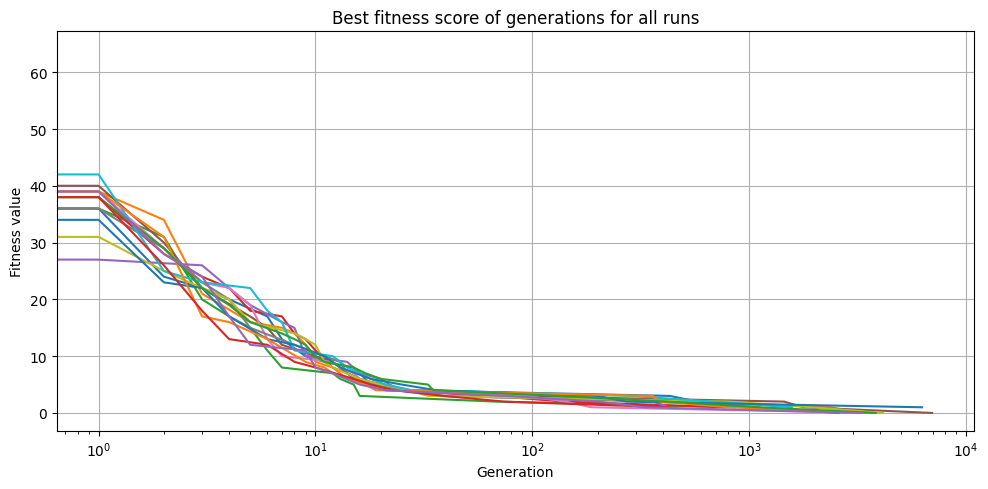

In [ ]:
# Running and result plotting ------------------------------------------------------------
# Prepare csv file for fitness data
fields = ["Generation", "Fitness_value", "Chromatic_number"]
with open(csv_name, 'w') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(fields)

# Execution of genetic algorithm
results = [genetic_algorithm(num_generations, population_size, crossover_probability,chromatic_number, mutation_probability, all_fitness) for _ in range(num_runs)]

# Get total success rate of all runs
num_successes = sum([1 for result in results if result[1] == 0])
success_rate = num_successes/num_runs

# Get average fitness for all runs
# This is absolutely fucking dumb way to sum it all but I need it fast for the pojednani
fit_sum = 0
len_fit = 0
chroma_mins = []
for i in range(num_runs):
  fit_sum += np.sum(results[i][3])
  len_fit+= len(results[i][3])
  chroma_mins.append(min(results[i][4]))
avg_fitness = fit_sum/len_fit


print(f'Done! Total success rate is {success_rate*100} % with average fitness {avg_fitness} and smallest found chromatic number {min(chroma_mins)} ')

# Plot the course of the fitness function for each run
figure, ax = plt.subplots(figsize=(10, 5))
for i in range(len(results)):
    ax.plot(*zip(*results[i][2]) )
ax.grid()
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness value')
ax.set_xscale('log') # better to have log scale for generations axis   due to slow descent in the beginning
plt.title('Best fitness score of generations for all runs')
plt.tight_layout()
plt.show()

[[ 0  5]
 [ 1  1]
 [ 5  7]
 ...
 [11  0]
 [ 0  5]
 [ 1  0]]


Text(0.5, 1.0, 'Konvergencni krivka')

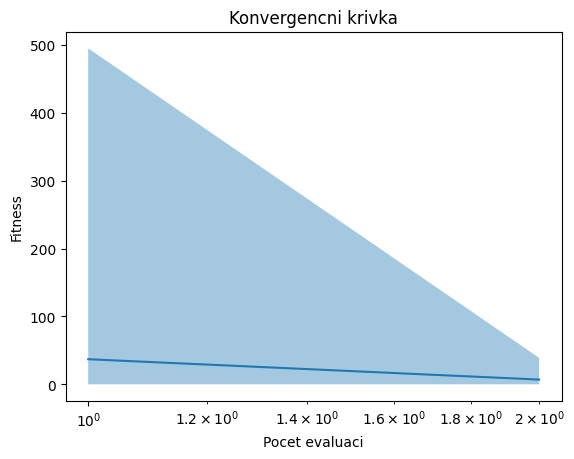

In [ ]:
best_history_lists = [result[2] for result in results]
xy = np.concatenate(best_history_lists)

mins = np.min(xy, axis=0)
meds = np.median(xy, axis=0)
maxs = np.max(xy, axis=0)
print(xy)
xy.shape
plt.xscale('log')
x = np.arange(1,2+1)
plt.plot(x,meds)
plt.fill_between(x,mins,maxs,alpha=0.4)
plt.xlabel('Pocet evaluaci')
plt.ylabel('Fitness')
plt.title('Konvergencni krivka')
